# Web Mapping and Analysis Coursework 1: Comparing Distances from Universities/Colleges to the students closest Public Mental Health building within London.

## Part 1: Introduction and explaining the purpsoe of the map
 
This assignment revolves around creating routes from local colleges to mental health buildings within LSOA’s (Lower Layer Super Output) that have low reachable health scores since this a service that is not currently provided by the NHS directly. This will display the lack of growth over new mental health facilities even though there has been a significant surge in the number of student’s requiring mental health at a 94% growth from the year before (Hindle, Lambart and Plackett, 2018).

In [16]:
%matplotlib inline
# allowing for components to be rendered inframe
from IPython.display import IFrame
#installing the mathematical functions modules
import math
# Useful module for allowing to create base map PNG's without constantly referring to a Database which is the laternative in QGIS
import contextily as cx
# Module which allows for shp and csv files to be moulded into a geographical table and allow for XY plotting
import geopandas as gpd
# extrating objects from the JSON request function and allowing them to be interpulated into JSON formates
import json
# the the pyplot funciton allows for graphs/arrays to be plotted onto a graph for a visual representation before QGIS
import matplotlib.pyplot as plt
#base pandas allows for table sets to be modeled into a predenfined table set which rows and collumsn can be manipulated
import pandas

# Most important import tool as this allows for communication to the outside world
import requests
#the time function is used as certain API's have a time contraint on how many calls can be made within a time period
import time
# Shalpy points was used in testing to point gemortry sections to allow for points to have labels
from shapely.geometry import Point

#STANDARD GEOGRAPHIC MODULES
#Importing numpy allowing for mathematicl operations
import numpy as np
#Pandas importing which allow to edit Dataframe data sets in csv and xlsx
import pandas as pd
#Geopandas allows for GeoDataframe and polygon rendering for SHP objects
import geopandas as gpd
# pysal Python Spatial Analysis Library allows for chropleth mapping
import pysal as ps
#Seaborn is used to use techniques such as 
import seaborn as sns
# matplot allows for graphs to be created for morans I and XY graphs
import matplotlib.pyplot as plt
#DBSCAN method for noise and main points for point method
from sklearn.cluster import dbscan
# reducing the datasets from a large amount to a usable amount
from functools import reduce
# allowing interactive and fixed elements on a HTML envrionment for Python
from ipywidgets import interact, fixed

#Choropleth and LISA CREATION
#allowing for matplotinline creation without object creation
%matplotlib inline
#moran plotting weighted attributes for each variable for standarization
from pysal.lib import weights
# morans ESDA for plotting and achieveing Moran values
from pysal.explore import esda
# for LISA and spatial autocorrelation plotting of points in a LSOA
from pysal.viz.splot.esda import moran_scatterplot, lisa_cluster,plot_local_autocorrelation
#used for background maps for graph creation
from IPython.display import Image

In [2]:
# Initial idea involved using set geomotry points before using a dynmaic method with tomtom but this is kept to display testing
geoJSONPointsURL ='PointsofLondon.geojson'


',SRV0020,SRV0338,SRV0481,SRV0055,SRV0061,SRV0074,SRV0318'

In [38]:
# Functions that are used constantly through out this assingment

In [3]:
# URL FOR DOCUMENTATION:  https://developer.api.nhs.uk/
# This is the first of the many functions that will be used within the piece of coursework.
# This function allows takes the Longitude and Latitude values of a coordinates across the global and order every organisation
# the earch search of SRV0002 which is the code for "Mental Health Hopsital"

# RETURN**. the return will be a JSON value of the organisation nade which will be used for points and Address which will
# be used on the PostcodeAPi to find the coordinate location 
def universityNHSMentalClosest(long, lat):
    #initialising the string set that will replace LONG,LAT with the values passed in. It will order the SQLDB to the LONGLAT
    # Passed in
    userData = u'''
{
    "searchFields": "ServiceCodesProvided",
    "search": "SRV0002",
    "orderby": "geo.distance(Geocode, geography'POINT( LONG LAT)')",
    "select": "OrganisationName,Address1,Address2,Address3,City,County,Postcode",
    "top": 1,
    "skip": 0,
    "count": true
}
    '''
    #these values are used instead of hardcodign the variable as the data set is called approxmialy 125 times
    userData= userData.replace('LONG', long)
    # Chaning the lat value into the string value from the function
    userData= userData.replace('LAT', lat)
    
    # building the variables to pass in and the url to send to.
    # the request is a GET request with the variables above which are, the closest 1 variable that is closest to the points passed
    # in. This will send the closest with the oragniation name and postcode for further development
    response = requests.request(
    method='POST',
    url='https://api.nhs.uk/service-search/search?api-version=1',
    headers={
        'Content-Type': 'application/json',
        'subscription-key': '5fe3d1d10b604b3b93c4d336265b2042'
    },
    data=userData
  , )
    # the function works on a .then(()=>{}) method so the function will wait until a value has been returned as it only works using
    # a single core unless explicilty asked for. The content is then formatted into a JSON object and returned.
    return json.loads(response.content)

#### Follow up about the NHS API (affect of coursework to the NHS)
After realising the shocking lack of mental health buildings in London (from this assignment) comparatively to Government’s knowledge that Universities don't work as closely to the NHS with mental health as they should be (BBC News, 2018b), I contacted the NHS API support team to make them aware spread awareness. A week later after no response, you could no longer search for any Mental Health service within the API without knowledge of their code. Funding needs to be invested and will be given to the government and NHS with the statistical data proven from this assignment.

In [44]:
Image(url= "https://i.imgur.com/GyQ4my3.png")


Figure 1: rendering email sent before the affect I had on the application and assingment made he team remove searching mental health services on the API

In [4]:
#DOC FOR REFERENCES: https://postcodes.io/
# This function will work alongside the NHS api as the NHS search service is not allowed to give exact coordinate points 
# but using the Postcode api you can give a postcode from the globe and the Geolocation points can be found.
# This is useful for the further mapbox function that will be used down the line
def postCodeLONGLATFunc(postCode):
    # First we need to remove any obscure componets with the function such as spaces as the NHS api sends
    postCode= postCode.replace(" ", "");
    #Then send the request with the url and parametes being the POSTCODE to search
    t = requests.get('https://api.postcodes.io/postcodes/'+ postCode)
    #the try is down to if the postcode cannot be found a basecase will be used instead
    #print(t.content)
    try:
        #return values if successfull if not it will not retrun and go to the except section
        return str(json.loads(t.content)['result']['longitude']),  str(json.loads(t.content)['result']['latitude'])
    except:
        #return a pregenerated coordinates to the middle of london
        return str('-0.1383'), str(' 51.6481')


In [5]:
# this is my personal token for matplot which the university of Liverpool has given a key to myself
TOKEN = "pk.eyJ1IjoiZWFtb251bmkiLCJhIjoiY2s1d21jMWxvMWcyYTNobG84dXExMHFvNyJ9.A0sRQiSp8YqIuGP9W4mBwQ"

In [6]:
#URL FOR DOCUMENTATION: https://docs.mapbox.com/api/?language=CLI&utm_medium=sem&utm_source=google&utm_campaign=sem|google|brand|chko-googlesearch-pr01-dynamicsearchcampaign-nb.broad-all-landingpage-search&utm_term=brand&utm_content=chko-googlesearch-pr01-dynamicsearchcampaign-nb.broad-all-landingpage-search&gclid=Cj0KCQiAhojzBRC3ARIsAGtNtHUr3omU1rMk8VSVBmp_8EYdl1NsmOnmr31xoI-hR0uESrUnxqhUfxoaAuTEEALw_wcB
# This function is a routing function as it uses matplot lib. to find routes from two different coordinates
# As shown above the coordinates that will be used are the local Mental Health hospitals and local universites within deprivated
# areas according to the LISA analysis 
# OrigLat, OrigLong, DestLat, DestLong = the coordinates Orig are the education institutions and Dest are the hosptials
# tok is the token for verification as Matplot is a pay as you go service
def distanceFromPointToPoint(OrigLat, OrigLong, DestLat, DestLong, tok):
    #Creating the base message with the url preset and empty values which will be altered in the function
    dir_base = ("https://api.mapbox.com/directions/v5/mapbox/"\
"XXXmodeXXX/"\
"XXXorig_lonXXX,XXXorig_latXXX;"\
"XXXdest_lonXXX,XXXdest_latXXX"\
"?geometries=geojson"\
"&access_token=YOUR_MAPBOX_ACCESS_TOKEN")
    
    #replacing template values with Geolocation values that are passed in
    query = dir_base.replace("XXXmodeXXX", "walking")\
    .replace("XXXorig_lonXXX", OriginLong)\
    .replace("XXXorig_latXXX", OriginLat)\
    .replace("XXXdest_lonXXX", DestLong)\
    .replace("XXXdest_latXXX", DestLat)
    #send request with values changed
    r = requests.get(query.replace("YOUR_MAPBOX_ACCESS_TOKEN", tok))
    #load json values and return the value
    waypoints = json.loads(r.content)
    return waypoints

In [7]:
#URL FOR DOCUMENTATION: https://developer.tomtom.com/content/search-api-explorer#/
#purpose of this function is for from the geolocations inserted to find
def tomTomGeomotryInput(GeoLONG, GeoLAT, Radius):
    #the tom tom search api which has a search period of university using a circle radius of the raduis passed in. The geolocation from the totom api
    tomTomInput = 'https://api.tomtom.com/search/2/geometrySearch/university.json?geometryList=%5B%7B%22type%22%3A%22CIRCLE%22%2C%20%22position%22%3A%2251.5009%2C%200.1220%22%2C%20%22radius%22%3A6000%7D%5D&limit=5&idxSet=POI&key=A8mAjgj7CPtqxdesF27a1PYHwCdvIHCK'
    #tomTomInput = 'https://api.tomtom.com/search/2/geometrySearch/university.json?geometryList=%5B%7B%22type%22%3A%22CIRCLE%22%2C%20%22position%22%3A%2251.5009%2C%200.1220%22%2C%20%22radius%22%3A6000%7D%5D&limit=100&idxSet=POI&key=A8mAjgj7CPtqxdesF27a1PYHwCdvIHCK'
    #replacing generic 6k value with user. alue passed in
    tomTomInput = tomTomInput.replace('6000',Radius)
    #remove basic value with the coordinate LAT passed in
    tomTomInput = tomTomInput.replace('51.5009',GeoLAT)
    # altering the basic values with the values that are passed in
    tomTomInput = tomTomInput.replace('0.1220',GeoLONG)
    #send a request from the tomtom request api
    TomTomDataResponse = requests.get(tomTomInput)
    #return the JSON array list that the request sends
    return json.loads(TomTomDataResponse.content)

In [8]:
# when each result is sent and only values that have universit or college within the values
def getAllCollegeAndUniversityFromEducation(Tomtom):
    #create an empty array set for each coordinate point
    UniandCollege = [];
    #When you go through array list for the LISA analysis set 
    for i in Tomtom['results']:
        #or i['poi']['name'].find("College") != -1
        # if the values for each array element conform to the name parameters
        if i['poi']['name'].find("Universit") != -1 or i['poi']['name'].find("College") != -1:
            #append the array tomtom location to array set that have universit or college in the name
            UniandCollege.append({
                'name': i['poi']['name'],
                'lat': str(i['position']['lat']),
                'lon': str(i['position']['lon'])})
            
    # return the array set with the array appended values
    return UniandCollege

In [9]:
#GEO LOCATION FOR REFERENCE: https://docs.mapbox.com/api/search/
# values that are passed in are the name values of each location and their locations
#origin was the educational institution and destination is nhs mental health institution
def distanceRouteMAPBOXAPI(originLon, originLat, destLon, destLat, name, NHSOrganisation):
    #originLon, originLat, destLon, destLat
    #base URL to the beginning as the origin
    dir_base = ("https://api.mapbox.com/directions/v5/mapbox/"\
        "XXXmodeXXX/"\
        "XXXorig_lonXXX,XXXorig_latXXX;"\
        "XXXdest_lonXXX,XXXdest_latXXX"\
        "?geometries=geojson"\
        "&access_token=YOUR_MAPBOX_ACCESS_TOKEN")
    # my token url for mapbox just to clarify
    TOKEN = "pk.eyJ1IjoiZWFtb251bmkiLCJhIjoiY2s1d21jMWxvMWcyYTNobG84dXExMHFvNyJ9.A0sRQiSp8YqIuGP9W4mBwQ"
    #editing the values with the params from the function
    query = dir_base.replace("XXXmodeXXX", "driving")\
        .replace("XXXorig_lonXXX", originLon)\
        .replace("XXXorig_latXXX", originLat)\
        .replace("XXXdest_lonXXX", destLon)\
        .replace("XXXdest_latXXX", destLat)
    #replacing the value to the api token key that is within the function
    r = requests.get(query.replace("YOUR_MAPBOX_ACCESS_TOKEN", TOKEN))
    #load the values from the GET value
    waypoints = json.loads(r.content)
    #allow the route to be the waypoint location from the mapbox values array
    route = waypoints['routes'][0]
    #properties are saved as properties to allow for further assessment and associaition with the labeling of information
    route['properties'] = {"distance": waypoints["routes"][0]["distance"],
        "duration": waypoints["routes"][0]["duration"],
        "originalCoordinates": {originLon, originLat},
        "destinationCoordinates":  {destLon, destLat},
        "Education": name,
        "NHSOrg": NHSOrganisation
    }
    
    # return the JSON dictionary object that was created from the MAPBOX apo resulting data
    return route;

In [19]:
#url for spatial dataset
assingnment = 'E12000007/spatial/E12000007.shp'

In [20]:
#setting the index for the points
londonHealth = gpd.read_file(assingnment).set_index('lsoa11cd', drop=False)

In [21]:
#Initialised what CRS type this dataset would be for simple plotting
londonHealth = londonHealth.to_crs({'init': 'epsg:4326'})

In [22]:
#Displaying the data
# Instead of merging data sets when testing it was found that a lot of them were not focused around health services but
# around the physical health of the LSOA area and this was not reelvemnt to our field accept for h_dom which was the
# services in the area and the reachability score.
londonHealth.head(2)

,lsoa11cd,r_dec,h_dec,e_dec,ahah_dec,r_dom,h_dom,e_dom,ahah,geometry
lsoa11cd,,,,,,,,,,
E01000001,E01000001,10,1,10,10,81.246805,0.354719,99.665955,59.821815,POLYGON ((-0.09597810309633811 51.517170528601...
E01000002,E01000002,10,1,10,10,72.999589,0.482147,98.971820,56.914495,POLYGON ((-0.09347306278408797 51.517727275537...


## Reasons for data selection

A major choice of this was done after finding the NHS API which, had a feature to search for local services using a filter. This was the main starting point of the map’s creation as after finding statistical data with health ratings within London using the CDRC web page, a scope of an area was found. After performing a LISA (Local Indication of Spatial Association) groups will be segregated into five areas in levels of an effect that the health statistic will play. This is a perfect representation of the 2.3 million student population in England and allows for different segregations to display. at different tile zoom levels(BBC News, 2018a). The sector to focus on within the NHS was mental health as the department of health has said it has “failed a generation” with the lack of funding and support to students who are unaware of their local GP’s and support facilities (BBC News, 2018a). After extra research was done the choice of route paths from the tutorials was combined with the educational sector as it was found through a 2018 leak of budget cuts that the government had planned within London for £183.1m in budget cuts over four months affecting up to 1.4 million users who live in the area linked with education and mental health (Guardian, 2018).

In [23]:
# Since we didn't need these collumns andthey slow down and break the LISA choropleth analysis for shier
#code size
londonHealth= londonHealth.drop(columns=['r_dec','h_dec','e_dec','ahah_dec','r_dom','e_dom','ahah'], axis=1)

In [24]:
# New table after removing irrelevent collumns
londonHealth.head(2)

,lsoa11cd,h_dom,geometry
lsoa11cd,,,
E01000001,E01000001,0.354719,POLYGON ((-0.09597810309633811 51.517170528601...
E01000002,E01000002,0.482147,POLYGON ((-0.09347306278408797 51.517727275537...


In [25]:
#Create Queen and rook spatial auto correlation on londonHealth with the index variables.
# Method ofconnecting data sets together through the Queen and rook approach from a spatial matrix on 'h_dom' 
%time w = weights.Queen.from_dataframe(londonHealth, idVariable='lsoa11cd')

CPU times: user 19.6 s, sys: 460 ms, total: 20.1 s
Wall time: 20.4 s


In [26]:
#Time frame only took 17.2 seconds since dropped the unused values
# standardize the matrix for each row
w.transform = 'R'

In [27]:
#Create spatial lag with the deprivationrate values with the higher 
# the value meaning the higher the deprivation rating
# W is standardized with the average values of the varaible and its neighbourhoods
londonHealth['w_h_dom'] = weights.lag_spatial(w, londonHealth['h_dom'])

In [28]:
#Create a Local Indication of Spatial Autocolleration with the deprivation rate 
lisa = esda.Moran_Local(londonHealth['h_dom'], w)

In [29]:
# Break observations into significant or not
londonHealth['significant'] = lisa.p_sim < 0.05
# Store the quadrant they belong to
londonHealth['quadrant'] = lisa.q

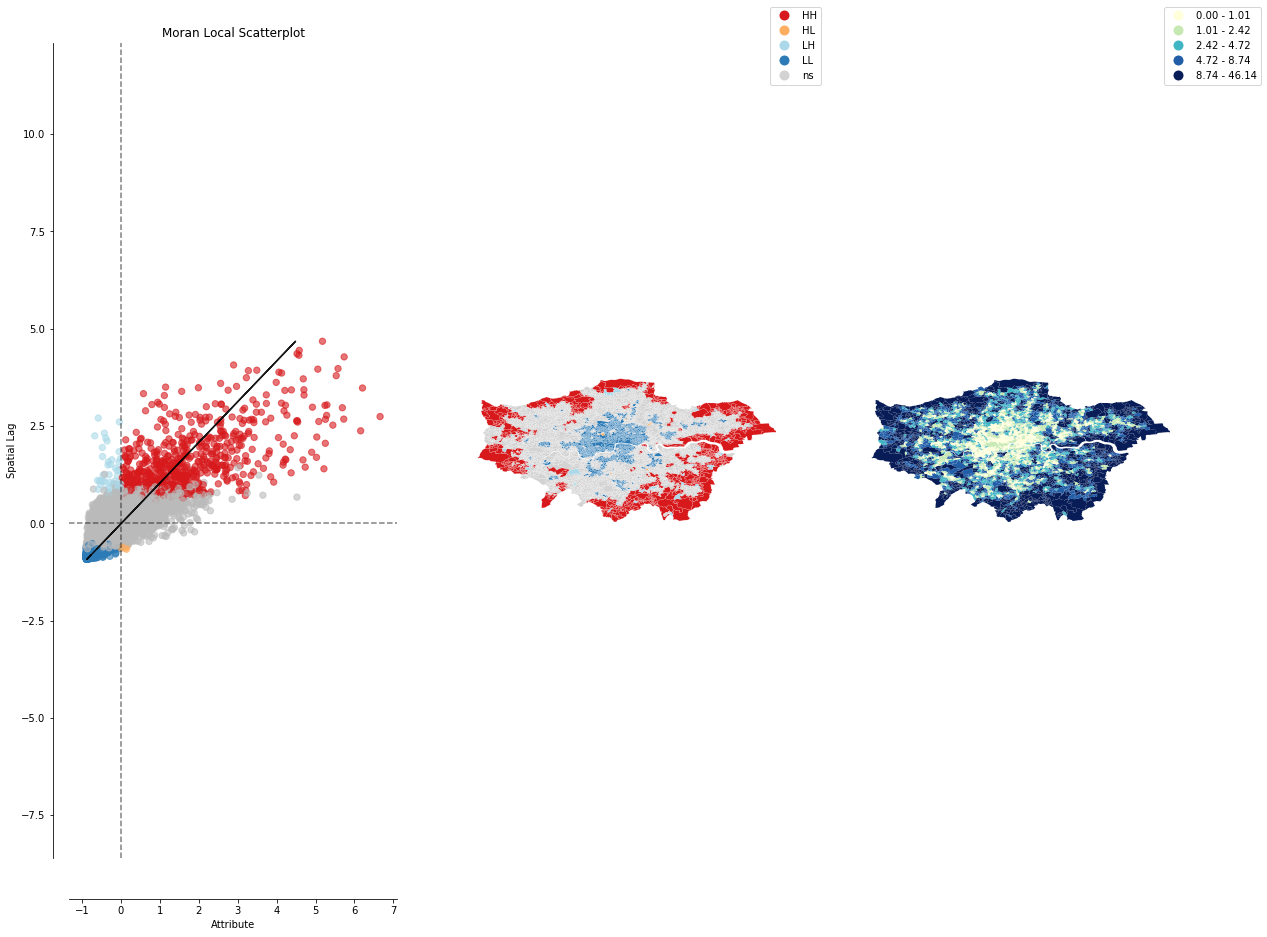

In [30]:
#Create a spatial autocorrelation 3 part 3
#1: LISA Morans I graph for correlation display
#2: LISA analysis for outliered variables and clustered points
#3: Chroropleth heatmap of produced values
plot_local_autocorrelation(lisa, londonHealth,'h_dom',figsize=(20,15))
#Showing plotted graphs for LISA analysis in 3 forms
plt.show()

In [22]:
# Setup the figure and axis 
# Create variables for all components to get all forms of LISA analysis
#NS = Non specified for all values that have no string spatial lag correlation between surrounding nodes
ns = londonHealth.loc[londonHealth['significant']==False, 'geometry']
#  HH clusters values for quadrent values and the values are significant 
hh = londonHealth.loc[(londonHealth['quadrant']==1) & (londonHealth['significant']==True), 'geometry']
#  LL clusters values in the quadrent 3 which is the Low Low values
ll = londonHealth.loc[(londonHealth['quadrant']==3) & (londonHealth['significant']==True), 'geometry']
#  LH clusters for low values surrodunded by high values
lh = londonHealth.loc[(londonHealth['quadrant']==2) & (londonHealth['significant']==True), 'geometry']
#  HL clusters that are High values then have a surrounding by a low value
hl = londonHealth.loc[(londonHealth['quadrant']==4) & (londonHealth['significant']==True), 'geometry']
#Values that will be used in the next step is Hl and HH since the higher the skewed values the higher the 
#deprivation rate

## Part 2 Purpose for each data selection aspect

The main motive of the statistical data selection was the health rating of London. This was chosen to be static and locally saved as there hasn’t been any drastic money investment over recent years into mental health as it was predicted that £105 million less was invested into the NHS within 2016-2017 than 2011- 2012 (TUC, 2018). As health is the topic it was found that Mental Health was the sector with the least amount of funding as only 63 percent of mental health trusts received more funding than the previous year (TUC, 2018). 
On the contrary, live data was used with mental health service locations as to use the direct source of GP’s and NHS web applications the NHS WEB API Portal. Education was the minority group chosen within the mental health sector since it was reported that 95 students committed suicide in 2017 in England and Wales alone and have increased over recent years (BBC News, 2018c). Not only this but the government has made it clear to Universities that they must “dramatically improve” the support they give students with their mental health facilities which is what this map is attempting to assist with (BBC News, 2018b). 


In [46]:
Image(url= "https://i.imgur.com/KGzNfGO.png", width=500)

Figure 2: Displaying Suicide rate linked within higher education (BBC News, 2018c)

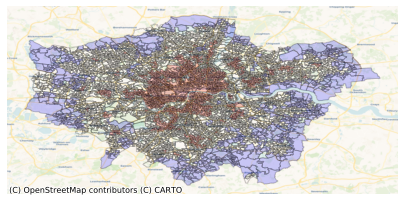

In [23]:
# Setup the figure and axis for testing purposes so I know what the LISA choropleth will look like
f, ax = plt.subplots(1, figsize=(7, 7))
# Plot insignificant clusters which is NS for non significant which will display LSOA blocks on maximum range
ns = londonHealth.loc[londonHealth['significant']==False, 'geometry']
# plotting the values with gemotry plot 
ns.plot(ax=ax, alpha = 0.2,  facecolor='none', edgecolor='black')
# Plot HH (High High) clusters within the second coadriant and are significant within this field and the geomotry fields are saved
hh = londonHealth.loc[(londonHealth['quadrant']==1) & (londonHealth['significant']==True), 'geometry']
# the hh shp file is saved for QGIS
hh.to_file('foldersave/hhVal/hhChoropleth.shp')
# plotting highigh quadrant as blue to display 
hh.plot(ax=ax, color='blue', alpha = 0.2, edgecolor = 'black', linewidth=1)
# Plot LL clusters location and using these points as the signficant quadrent within quadrent 3
ll = londonHealth.loc[(londonHealth['quadrant']==3) & (londonHealth['significant']==True), 'geometry']
#plot red for low low areas
ll.plot(ax=ax, color='red', alpha = 0.2, edgecolor = 'black', linewidth=1)
# Plot LH clusters
lh = londonHealth.loc[(londonHealth['quadrant']==2) & (londonHealth['significant']==True), 'geometry']
# low high values being plotted that will be saved further on
lh.plot(ax=ax, color='#83cef4', alpha = 0.2, edgecolor = 'black', linewidth=1)
# Plot HL clusters within the quadrent
hl = londonHealth.loc[(londonHealth['quadrant']==4) & (londonHealth['significant']==True), 'geometry']
# plot. the high low points with a darker red
hl.plot(ax=ax, color='#e59696', alpha = 0.2, edgecolor = 'black', linewidth=1)
# Style and draw
# creation base map with the crs 4236
cx.add_basemap(ax, crs=londonHealth.crs, url=cx.providers.CartoDB.Voyager)
#initialising the axis of set so the x and y coordinates arenot found
ax.set_axis_off()
# saving the file didnt work as there are so many gemotry shapes with  1000+
#plt.savefig('x1.tif', dpi=100, quality=80)

The LSOA data set has a LISA (Local Indicators of Spatial Association) analysis performed on it to allow for low and secluded low areas to be differentiated at different zoom levels on the final map with definition. The centroid values of each deprived region is fed into the TomTom API to find geolocations of local Univerisites/Colleges. Data from the TomTom API is used to highlight the name and locations of each origin point for the Map Box API route creator. On the other hand, the NHS API will find the name and location of the closest Mental health clinic, which the Postcode API will take advantage of and give geolocation coordinates from the Postcode. The NHS API gives official NHS names for the clinic so these can be used as labels for medical centres and the Tomtom API will be used to label each education point used. 

In [51]:
Image(url= "https://i.imgur.com/xq2AWYS.png", width=400)

Figure 3: Showing what each data set and function does with one another in conjunction to create the final map

In [89]:
#Ensuring  the low coordinates again then to save the file
ll = londonHealth.loc[(londonHealth['quadrant']==3) & (londonHealth['significant']==True), 'geometry']
# Saving file to the folder components
ll.to_file('foldersave/llVal/llChoropleth.shp')

In [90]:
#Ensuring  the lowhigh coordinates again then to save the file
lh = londonHealth.loc[(londonHealth['quadrant']==2) & (londonHealth['significant']==True), 'geometry']
# Saving file to the folder components
lh.to_file('foldersave/lhVal/lhChoropleth.shp')

In [91]:
#Ensuring  the highlow coordinates again then to save the file
hl = londonHealth.loc[(londonHealth['quadrant']==4) & (londonHealth['significant']==True), 'geometry']
# Saving file to the folder components
hl.to_file('foldersave/hlVal/hlChoropleth.shp')

In [92]:
#Ensuring  the now satisfactory coordinates again then to save the file
ns = londonHealth.loc[londonHealth['significant']==False, 'geometry']
# Saving file to the folder components
ns.to_file('foldersave/nnVal/nnChoropleth.shp')

In [93]:
# getting a geodataframe shallow copy of the object to edit and tamper with
hhgdfa = gpd.GeoDataFrame(gpd.GeoSeries(lh))
# remove geonotry to allow for joins on traditional dataframe
londonHealthNoGeo = londonHealth.drop(columns=['geometry'])
#Join the LISA analysis with values to allow for sorting
hhgdfa= hhgdfa.join(londonHealthNoGeo, on='lsoa11cd')
#sort the worst in order as a cut off might haft to be established later on
finalValue=hhgdfa.sort_values(by=['h_dom'], ascending=True)
# find the centroid values of each geomotry to get points
u = finalValue.centroid

In [94]:
#initialisise the coordinate array
geoJSONGPD = []
#itterate through each coordinate and select its x and y coordinates to append to a new array
for i in range(len(u)):
     geoJSONGPD.append([round(u[i].bounds[0],4), round(u[i].bounds[1],4)])

In [36]:
#create an array for the longitude and lattidue of mental health buildings
NHSMentalHealthLonLatArray = [];
#will be the postcode to search by
nhsMentalHealthPostCode = "";
#will be used later on but initialised with other vairaibles here
route = [];
#go through each x y cordinates
for rangers in geoJSONGPD:
    #print(str(rangers[0]), str(rangers[1]))
    # Go into the tomtom api with a range of 6000m and find local educational institutions on the area
    getAllUniversitiesInArea = tomTomGeomotryInput(str(rangers[0]), str(rangers[1]), '6000')
    #print('before filter'+ len(getAllUniversitiesInArea))
    #filter out any school or education centre that is not a college or university
    getAllUniversitiesInArea = getAllCollegeAndUniversityFromEducation(getAllUniversitiesInArea)
    #print(len(getAllUniversitiesInArea))
    #for each university college find the local mental health institutions post code and name
    for uniList in getAllUniversitiesInArea:
        NHSMentalHealthLonLatArray.append(uniList)    

NameError: name 'geoJSONGPD' is not defined

In [96]:
# After gettign every college and university from each coordinate a inique check on the name is done so only unique values are filtered
NHSMentalHealthLonLatArray = list({v['name']:v for v in NHSMentalHealthLonLatArray}.values())

In [97]:
#length from 117 to 36 after filtering
len(NHSMentalHealthLonLatArray)

36

# Part 3: Web API Paragraph


An API (Application Program Interface) is a hosted server that can interact through HTTP and HTTPS calls for URI/URL links for certain pieces of information between two applications. API’s are commonly found to be using a RESTFUL architecture and transfer either XML or JSON data to the recipient.
These applications are often connected to a backend database which retrieves information and outputs a result commonly through GET, POST and DELETE protocols, that allows for multiple users to interact and work together to add and amend datasets. In an OSI model between two users, an API works on the third and fourth layer the transportation and session layers.


In [53]:
Image(url= "https://i.imgur.com/NgN3YIz.png", width=350)

Figure 4: Displaying OSI model where the API works on the Session and Transport layer (Ames, 2019)

In [98]:
# Main section with NHS longitude and lattidude
nhsMentalHealthPostCode = "";
#initialise temp value sfor postcode and geolocation cordinates
coordinates = ""

#go through each univresity and cp;;ege om the area of LH
for i in range(len(NHSMentalHealthLonLatArray)):
    #sleep for 5 seconds as the calls for the NHS service search api is limited to 1 every 7 seconds and 3 seconds are down to latency
    time.sleep(5)
    #getting the closest NHS postcode from the education geolocation coordinates from the TOMTOM api
    nhsMentalHealthPostCode = universityNHSMentalClosest(NHSMentalHealthLonLatArray[i]['lon'], NHSMentalHealthLonLatArray[i]['lat'])
    #print(nhsMentalHealthPostCode['value'][0]['Postcode'])
    #after sending the sleep is done for 5 seconds
    time.sleep(5)
    #print("nhsMentalHealthPostCode")
    # using the postcode api to find the geolocation given the NHSMENTALHEALTHPOSTCODE value from the NHS server
    coordinates = postCodeLONGLATFunc(nhsMentalHealthPostCode['value'][0]['Postcode'])
    # using the return value to be from the coordinates values
    NHSMentalHealthLonLatArray[i]['closestMHNHS'] = coordinates
    # the NHS name is the original value from the NHS value
    NHSMentalHealthLonLatArray[i]['OrganisationName'] = nhsMentalHealthPostCode['value'][0]['OrganisationName']



The API’s used allows for the Jupyter notebook to be dynamic and retrieve stored data that are used by the NHS for all applications and assignment of Hospital appointments for the public. Not only this, the Postcode API is used in conjunction to find the Longitude and Latitude of these Mental health services for accurate geolocation selection even if a mental health service were to change location. Local College and Universities in health deprived areas can be found within a 6000M radius with live tagged geolocation data with the Tomtom API as well so if ran in three years’ time every new declared university and college can be shown so nothing is static.

In [49]:
Image(url= "https://i.imgur.com/P8ElQsH.png", width=500)

Figure 5: Creation of the entire API json data tranfer from user request and API sending before QGIS

A Routing API in Map box allowed for the distance between each local mental health building to a college to be found as a visual representation through efficient route planning. This is done around current climate, construction and walking limitations. These datasets allows for the data to be dynamic as possible since the. only non movable aspect is the areas that are the centroid focal points of each LSOA gemotry shape from the LISA analysis.

In [157]:
#route is set to initially be 0 array length
route = []
coordinatesNHSandEducation = []
      #      "EducationPointsLat" : float(originLat),
     #   "EducationPointsLon" : float(originLon) ,                          
     #   "MentalHealthpointLat": float(destLat) ,
      #  "MentalHealthpointLon": float(destLon) , 
#going through every nhs mental health oranigation
for uni in NHSMentalHealthLonLatArray:
    # from the destination and origonal long and lat vaues are sent to the mapbox api to get a roted path to it
    routing = distanceRouteMAPBOXAPI(uni['lon'], uni['lat'], uni['closestMHNHS'][0], uni['closestMHNHS'][1],uni['name'], uni['OrganisationName'])
    #append teh route values to be the routing coordinates
    route.append(routing)
    #append the coordinate values for the points.shp
    coordinatesNHSandEducation.append({
        "EducationPointsLat" : float(uni['lon']),
        "EducationPointsLon" : float(uni['lat']) ,                          
        "MentalHealthpointLat": float(uni['closestMHNHS'][0]) ,
        "MentalHealthpointLon": float(uni['closestMHNHS'][1])
    } )

In [158]:
#create a geodataframe from the array value
routes = gpd.GeoDataFrame.from_features(route, crs="EPSG:4326")

In [159]:
# setting the dataframe since using pointsfromxy using those values
coordinatestoGDF = pandas.DataFrame(coordinatesNHSandEducation)
#initialise the dataframe
coordinatestoGDFTwo = pandas.DataFrame(coordinatesNHSandEducation)
#points_from_xy are the points from the dataframe from the new copy
points = gpd.points_from_xy(coordinatestoGDF["EducationPointsLat"],
                            coordinatestoGDF["EducationPointsLon"]
                                  
                                 )
# creating the education coordinate points from the education point list
geoEducation = gpd.GeoDataFrame(coordinatestoGDF,
                                geometry=points,
                                crs="EPSG:4326"
                               )
# getting the points array for the mentalhealth X,Y
pointsMedi = gpd.points_from_xy(coordinatestoGDFTwo["MentalHealthpointLat"], 
                                coordinatestoGDFTwo["MentalHealthpointLon"]
                                  
                                 )
# create a dataframe so it can be saved later on
geoMedical = gpd.GeoDataFrame(coordinatestoGDFTwo,
                                geometry=pointsMedi,
                                crs="EPSG:4326"
                               )

In [160]:
# Create new params with the locations variable saved with the param properties within the route creation function
geoMedical['Medi'] = routes['NHSOrg']
# Creating the new param as the name of the educational institutions name for further development
geoEducation['Edu'] = routes['Education']


# Saving the geodataframe for the Coordinate points for educational and medical points
geoMedical.to_file('foldersave/lhPointsRoutes/lhPoints/medical/medicalPointsLH.shp')
geoEducation.to_file('foldersave/lhPointsRoutes/lhPoints/education/educationPointsLH.shp')

In [161]:
#displaying the level of data associated with the points
geoEducation.head(2)

,EducationPointsLat,EducationPointsLon,MentalHealthpointLat,MentalHealthpointLon,geometry,Edu
0,0.13913,51.43170,0.101687,51.419041,POINT (0.13913 51.4317),Goldsmiths College
1,0.12627,51.46082,-0.138300,51.648100,POINT (0.12627 51.46082),Bexley Adult Education College


In [175]:
#creating a new var which is a shallow clone of the routes array
routesSaveLL = routes;

In [176]:
#drop the collumns with duration, originalCoordinates, destinationCoordinates
# the distance is kept to be allowed to be used as display variables
routesSaveLL = routesSaveLL.drop(columns=['duration','originalCoordinates','destinationCoordinates'], axis=1)

In [177]:
# Information associated with each route.
routesSaveLL.head(2)

,geometry,distance,Education,NHSOrg
0,"LINESTRING (0.13918 51.431721, 0.140173 51.431...",6407.094,Goldsmiths College,Queen Mary
1,"LINESTRING (0.126251 51.460743, 0.125998 51.46...",72419.174,Bexley Adult Education College,Barefoot Lodge


In [178]:
# save the LH route to a file specified here
routesSaveLL.to_file('foldersave/lhPointsRoutes/lhRoutes/lhroute.shp')

In [8]:
#BASE MAP CREATION
#find the coordinates for each corner of the map from the lsoa boundries
w, s, e, n = londonHealth.total_bounds
# allow for some north area upper boundries to be 52
n = 52
# saving the file at zoom level 14 since itwas the highest dimensions possible before failure at the terminal end
# this will be used as the basemap in QGIS
img, ext = cx.bounds2raster(w, s, e, n, "creation.tif", ll=True, zoom=14, url=cx.providers.CartoDB.Voyager)


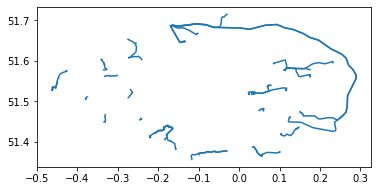

In [108]:
#ax = ll.to_crs(epsg=4326).plot(figsize=(15, 15), alpha = 0.1, edgecolor = 'black', linewidth=1, color='red')
#hh.to_crs(epsg=4326).plot(ax=ax, color='blue',alpha = 0.1, edgecolor = 'black', linewidth=1)
#hl.to_crs(epsg=4326).plot(ax=ax, color='purple',alpha = 0.1, edgecolor = 'black', linewidth=1)
#ax = routes.plot(figsize=(15, 15), color="black", linewidth=1)
#cx.add_basemap(ax, crs=routes.crs, url=cx.providers.CartoDB.Voyager)
#geoMedical.plot(ax=ax, markersize=30, color='red', marker='$H$')
#geoEducation.plot(ax=ax, markersize=30, color='green', marker="$E$")
#plt.savefig('x5.tif', dpi=500, quality=100)

#This was the initial creation before file saved with QGIS.
#display of the routes possible
routes.plot()

## Second zoom for middle of london to get different views

After the initial smaller data set for secluded aread a larger of data which can be found in the LISA analysis will be analysed. This is done another time with the second larger and bussier set to create multiple layers and allows a level of depth perception in the code.

In [54]:
Image(url= "https://i.imgur.com/CeTHk4G.png", width=400)

Figure 6: Zoom for previous data sets (first block of LISA analysis)

In [109]:
# After the LH values were found the same features were done on the ll values since when the user will zoom in more values will appear
llgdfa = gpd.GeoDataFrame(gpd.GeoSeries(ll))
# dropping the gemotry section as this is required for two files to be joined upon
londonHealthNoGeo = londonHealth.drop(columns=['geometry'])
# join the two values to create values and their corresponding health ratings
llgdfa= llgdfa.join(londonHealthNoGeo, on='lsoa11cd')
#sort them in ascending order so the lowest value is first
finalValue=llgdfa.sort_values(by=['h_dom'], ascending=True)
# get the centroid values of each LSOA gemotry shape
middlePoint = finalValue.centroid

# initialise the array to be empty
geoJSONGPDLL = []
# go through each piddle point and append it to an array to allow for easy iteration with functions
for i in range(len(middlePoint)):
    #doing the same as LH which is appending all the values bounds of [0] and [1]
     geoJSONGPDLL.append([round(middlePoint[i].bounds[0],4), round(middlePoint[i].bounds[1],4)])
#getting the first 30 values and saving it. these are ordered by lowest points so a prioepity is made on these low vlaues
geoJSONGPDLL= geoJSONGPDLL[:30]

In [111]:
# starting the low surroudned by low values array as this will be the second zoom level check
NHSMentalHealthLonLatArrayLL = [];
# each postcode will be sent to the postcode api with the variable as shown below
nhsMentalHealthPostCode = "";
# go through each json lowlow array from the centroid values
for rangers in geoJSONGPDLL:
    #print the values for checking and ensuring the API has not timed out
    print(str(rangers[0]), str(rangers[1]))
    #get the array of each educational orgnaiasiton that is under a college/university tag within 1000 m radius.
    # 1000 was chosen since a lot parts of the low low values are in the heart of Londion
    getAllUniversitiesInArea = tomTomGeomotryInput(str(rangers[0]), str(rangers[1]),'1000')
    # We will only select educational parts that are have univesrity or college in the title to avoid complex 2-D arrays
    #print('before filter'+ len(getAllUniversitiesInArea))
    getAllUniversitiesInArea = getAllCollegeAndUniversityFromEducation(getAllUniversitiesInArea)
    #print(len(getAllUniversitiesInArea))
    # Go through each education institutes array of positions and append it to a college/unviersity array list LON, LAT
    for uniList in getAllUniversitiesInArea:
        NHSMentalHealthLonLatArrayLL.append(uniList)    

-0.0916 51.4743
-0.2038 51.5139
-0.2108 51.481
-0.0578 51.5127
-0.1845 51.4387
-0.1544 51.5203
-0.1666 51.4241
-0.1398 51.5284
-0.1207 51.5795
-0.214 51.5548
-0.199 51.484
0.0046 51.5536
-0.1571 51.438
-0.0643 51.5258
-0.151 51.5198
-0.0184 51.4501
-0.1642 51.4922
-0.1767 51.4261
-0.1507 51.5454
-0.2064 51.5161
-0.1327 51.464
0.0285 51.5272
-0.1828 51.4814
-0.0792 51.4886
-0.1903 51.4875
-0.1962 51.5129
-0.1347 51.5277
-0.0527 51.5398
-0.1759 51.4845
-0.1589 51.5208


In [112]:
#removing any duplicate values within the name sector by only adding unique values to the list
NHSMentalHealthLonLatArrayLL = list({v['name']:v for v in NHSMentalHealthLonLatArrayLL}.values())

In [113]:
#seeing the final list length
len(NHSMentalHealthLonLatArrayLL)

30

In [114]:
# initialising the postcode value
nhsMentalHealthPostCode = "";
#coordinate values are set to an empty string
coordinates = ""
#itterate through the mental health lon lat array to get the Local nhs values
for i in range(len(NHSMentalHealthLonLatArrayLL)):
    # sleep the NHS search for 5 seconds
    time.sleep(5)
    # Use the search service and use the lon nat of each centroid
    nhsMentalHealthPostCode = universityNHSMentalClosest(NHSMentalHealthLonLatArrayLL[i]['lon'], NHSMentalHealthLonLatArrayLL[i]['lat'])
    #print(nhsMentalHealthPostCode['value'][0]['Postcode'])
    time.sleep(5)
    #print("nhsMentalHealthPostCode")
    #get the postcode coordinates from the postcode value of each NHS value
    coordinates = postCodeLONGLATFunc(nhsMentalHealthPostCode['value'][0]['Postcode'])
    #for the ith index set the coordinates to be the closetsMHNHS value
    NHSMentalHealthLonLatArrayLL[i]['closestMHNHS'] = coordinates
    # set the orangiation name to be the value from the NHS API so it can be used as a tag
    NHSMentalHealthLonLatArrayLL[i]['OrganisationName'] = nhsMentalHealthPostCode['value'][0]['OrganisationName']

     

In [55]:
Image(url= "https://i.imgur.com/Uixbiz2.png", width=400)

Figure 7: Next zoom layer when the next data set is also used

In [115]:
#start with the route to be an empty array
routeLL = []
#the cooridnates for the coordinates education and NHS array for the source and destination will be [] and be appended()
coordinatesNHSandEducationLL = []
      #      "EducationPointsLat" : float(originLat),
     #   "EducationPointsLon" : float(originLon) ,                          
     #   "MentalHealthpointLat": float(destLat) ,
      #  "MentalHealthpointLon": float(destLon) , 
# go through the coordinates from the step above
for uni in NHSMentalHealthLonLatArrayLL:
    #find the route from the education institution and the destination to be NHS medical institution
    routing = distanceRouteMAPBOXAPI(uni['lon'], uni['lat'], uni['closestMHNHS'][0], uni['closestMHNHS'][1],uni['name'], uni['OrganisationName'])
    # append the value as retruned
    routeLL.append(routing)
    # append the points for plotting on a different SHP file
    coordinatesNHSandEducationLL.append({
        "EducationPointsLat" : float(uni['lon']),
        "EducationPointsLon" : float(uni['lat']) ,                          
        "MentalHealthpointLat": float(uni['closestMHNHS'][0]) ,
        "MentalHealthpointLon": float(uni['closestMHNHS'][1])
    } )

In [116]:
#set the crs to be 4326 to allow for simple ussage
routesLL = gpd.GeoDataFrame.from_features(routeLL, crs="EPSG:4326")

In [166]:
# displaying what each dataset contains the original coordinates and the associated education and NHS parameters
routesLL.head(2)

,geometry,distance,duration,originalCoordinates,destinationCoordinates,Education,NHSOrg
0,"LINESTRING (-0.088454 51.467907, -0.088468 51....",462.694,152.273,"{-0.08794, 51.46768}","{51.468738, -0.091441}",William Booth College,Maudsley Hospital
1,"LINESTRING (-0.087285 51.46907, -0.08715000000...",747.066,238.085,"{51.46911, -0.08731}","{51.468738, -0.091441}",King's College London,Maudsley Hospital


In [136]:
# setting a dataframe to be from the array of coordinates
coordinatestoGDFLL = pandas.DataFrame(coordinatesNHSandEducationLL)
# createa a new variable since using points_from_xy will overwite the code
coordinatestoGDFTwoLL = pandas.DataFrame(coordinatesNHSandEducationLL)
pointsLL = gpd.points_from_xy(coordinatestoGDFLL["EducationPointsLat"],
                            coordinatestoGDFLL["EducationPointsLon"]
                                  
                                 )
#set a new variable for the same routes for LL education points
geoEducationLL = gpd.GeoDataFrame(coordinatestoGDFLL,
                                geometry=pointsLL,
                                crs="EPSG:4326"
                               )
# medication points will be set to be the array points for the longnitude and lattitude of each array value
pointsMediLL = gpd.points_from_xy(coordinatestoGDFTwoLL["MentalHealthpointLat"], 
                                coordinatestoGDFTwoLL["MentalHealthpointLon"]
                                  
                                 )
# get the new instance of the geodataframe
geoMedicalLL = gpd.GeoDataFrame(coordinatestoGDFTwoLL,
                                geometry=pointsMediLL,
                                crs="EPSG:4326"
                               )
# for each array get the geomotry routes to be the value from    routessaveLLPoints
geoMedicalLL['Medi'] = routessaveLLPoints['NHSOrg']
# for each array get the geomotry routes to be the value from    routessaveLLPoints
geoEducationLL['Edu'] = routessaveLLPoints['Education']

In [169]:
# set a new variable to allow for faultering
routessaveLLPoints = routesLL #'Education','NHSOrg'
# remove collumns for a faster save time since the ll (Low surroudned by low values) are 1000 plus
routessaveLLPoints = routessaveLLPoints.drop(columns=['duration','originalCoordinates','destinationCoordinates'], axis=1)
# save the routes path from MapBox to a file location
routessaveLLPoints.to_file('foldersave/llPointsRoutes/llRoutes/llroute.shp')


In [137]:
# save the point variables for medical infromation on low low LISA analysis values
geoMedicalLL.to_file('foldersave/llPointsRoutes/llPoints/medical/medicalPointsLL.shp')
# saving the point values for the education sectors that are in the low low bracket in the LISA analysis
geoEducationLL.to_file('foldersave/llPointsRoutes/llPoints/education/educationPointsLL.shp')

AttributeError: 'AxesSubplot' object has no attribute 'to_file'

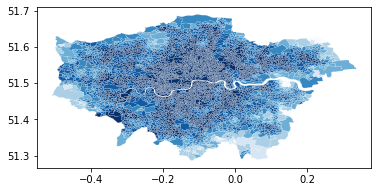

In [129]:
#Further testing with creating a choropleth of regions and their values of health region statistics
londonHealth.plot(column='w_h_dom', scheme='equal_interval', k=7, 
         cmap=plt.cm.Blues_r, alpha=1, 
         edgecolor='w', linewidth=0.1)
# used to compare the choropleth graph with the graph made in QGIS
plt.savefig('x3ss.tif', dpi=300, quality=100)

In [31]:
# Now after all the testing is complete the code will now be transfered onto QGIS

## Part 4: Tile-based Maps


Tile-based maps have three components, canvas display, styling and functionality. The canvas display is commonly a HTML empty body that will allow a scripting language such as JavaScript, Angular or React to manipulate the tag plane to display a map at a given state. The functionality (scripting language) will track the users dragging position and zoom level. Depending on the user’s position and zoom level a tile set will display according to their coordinates.

In [56]:
Image(url= "https://i.imgur.com/udwGZ0T.png", width=400)

Figure 8: Displaying the functionaility of how and what a Tile-Based map looks in a coding manner

Each tile is a png or jpeg image with the fully rendered section at that zoom level. Changing a zoom level will change the folder of images to use. Each zoom level stitches the various positions and renders them around an area that the user can view it. The higher the zoom level the more defined the image is showing more complex structures or details is common practise.
This technique is commonly used in a variety of popular applications such as Uber, Google Maps and the University of Liverpool Map app. These commonly use SDK’s, Packages or API’s so tile sets are simple with a plug and play mentality within the geographical coding world.


In [57]:
Image(url= "https://i.imgur.com/xFIawRm.png", width=400)

Figure 9: Displaying OSI model where the API works on the Session and Transport layer (Ames, 2019) 


Tile maps are what the final output of the graph is and uses many techniques with rendering techniques to only display features and point values when zoomed in to not clutter the map. When zooming in the map hide items such as the choropleth region, route distance values and most importantly the education positioning of more clutter areas and names.

# Steps done in QGIS
1. Drag and drop all the Shape gemotry files
2. Add the basemap
3. Edit colours to fit the aesthetic from the basemap
4. Add route layer
5. Add point coordinates (Education and Medical)
6. Edit colouring of point coordinates
7. Duplicate coordinate values
8. Add labels for Education and Medical
9. Change route colouring and duplicate layer
10. Add label for distance variable
11. Edit each layers visability scale for label layers
12. Add visability scale for the middle of london values

In [58]:
Image(url= "https://i.imgur.com/m1nSpz6.png", width=400)

Figure 10: Display of max zoom example of QGIS tile-based map

## Conclusion
Overall as a wrap-up it was found that each mental health sector in London was commonly associated with 2-4 Colleges and Universities which defiantly could not support each individual with the required time that they need. A further understanding was found with API’s even as a Computer Scientist to use larger datasets and to find methods to display the data effectively on a map that would illustrate your points. The east part of London was the wort offender of requiring students to travel for 72,000 m to their local Mental Health clinic. These and the avoidance of support from the NHS support team who took of searching Mental Health centres/clinics shows the gap of priority with physical and mental health is at in 2020.

Final QGIS output: https://theuniversityofliverpool-my.sharepoint.com/personal/sgemagdo_liverpool_ac_uk/_layouts/15/onedrive.aspx

# References: 

I. Ames. The OSI Model. A Medium Corporation (online). https://medium.com/software-engineering-roundup/the-osi-model-87e5adf35e10. 29 January 2019. (accessed 7 March 2020). 

BBC News. Mental health spending varies widely across England. https://www.bbc.co.uk/news/health-48228622. 14 May 2019. (accessed 3 March 2020). 

BBC News. Student mental health 'failing a generation'. https://www.bbc.co.uk/news/uk-44091501. 12 May 2018a. (accessed 5 March 2020). 

BBC News. Student mental health support must improve, universities told. https://www.bbc.co.uk/news/education-44635474. 28 June 2018b. (accessed 5 March 2020). 

BBC News. University student suicide rates revealed. https://www.bbc.co.uk/news/health-44583922. 25 June 2018c. (accessed 6 March 2020). 

D. Campbell and N. Hopkins. Leak shows 'devastating' impact of planned NHS cuts in London. The Guardian (online). https://www.theguardian.com/society/2017/jun/20/leak-shows-devastating-impact-of-planned-nhs-cuts-in-london 20 June 2017 (accessed 4 March 2020). 

J. Hindle, L. Lambert and C. Plackett. Mental health care is letting down students, agree NHS and university leaders. Universities UK (online). https://www.universitiesuk.ac.uk/news/Pages/mental-health-care-is-letting-down-students-agree-NHS-and-university-leaders.aspx 11 May 2018. (accessed 5 March 2020). 

Trades Union Congress (TUC). Breaking Point: the crisis in mental health funding. Industry Report. https://www.tuc.org.uk/sites/default/files/Mentalhealthfundingreport2_0.pdf 2018 (accessed 5 March 2020). 